In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import norm
import math as m 

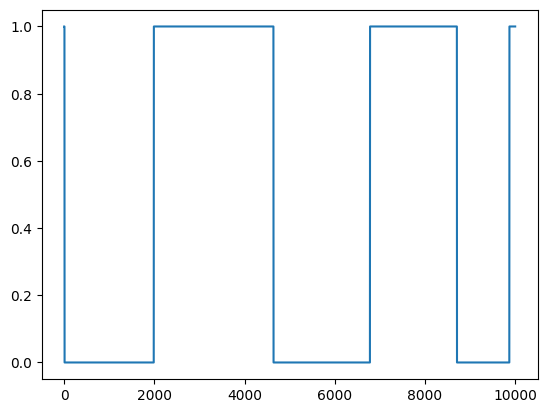

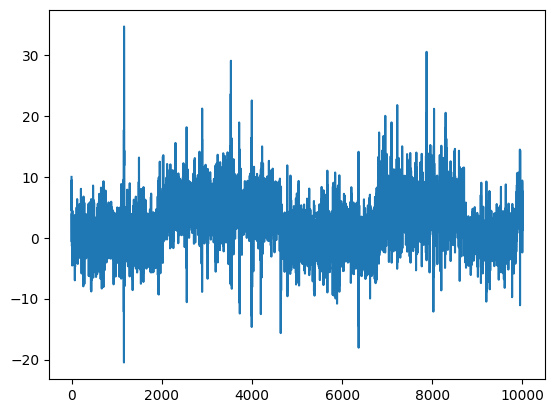

In [8]:
# генерация выборки

p_11, p_12, p_21, p_22 = 0.999, 0.001, 0.001, 0.999
t = 10000
xi_0 = [0.5, 0.5]

import random 
s = [random.choices([0, 1], weights=xi_0)[0]]
for i in range(1, t):
    if s[i - 1] == 0: s.append(random.choices([0, 1], weights=[p_11, p_12])[0])
    else: s.append(random.choices([0, 1], weights=[p_21, p_22])[0])

alpha = [0, 5]
beta_0 = [1, 1.001]
beta_1 = [0.3, 0.31]
gamma = [0.6, 0.61]

sigma_0sq = 10 # начнем с 10

z = norm.rvs(loc=0, scale=1, size=t, random_state=42) # вектор z_t


sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0[s[i]] + beta_1[s[i]] * epsilon[i - 1]**2 + gamma[s[i]] * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

y = []
for i in range(len(z)):
    y.append(alpha[s[i]] + epsilon[i])


plt.plot(s)
plt.show()
plt.plot(y)
plt.show()


In [ ]:
# функция правдоподобия

def calc_logL_fast(theta, sigma_0sq, y, t):

    alpha = [theta[0], theta[1]]
    beta_0 = [theta[2], theta[3]]
    beta_1 = [theta[4], theta[5]]
    gamma = [theta[6], theta[7]]

    xi_tt = []
    xi_ttm1 = [[0.5, 0.5]]
    phi = []
    sigmasq = [sigma_0sq]

    phi_0 = norm.pdf(y[0], loc=alpha[0], scale=sigmasq[0]**0.5)
    phi_1 = norm.pdf(y[0], loc=alpha[1], scale=sigmasq[0]**0.5)

    phi.append([phi_0, phi_1])

    dot_product = xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1]

    xi_0 = (phi[0][0] * xi_ttm1[0][0]) / dot_product
    xi_1 = (phi[0][1] * xi_ttm1[0][1]) / dot_product

    xi_tt.append([xi_0, xi_1])

    logL = m.log(xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1])

    for i in range(1, t):
        
        xi_0 = xi_tt[i - 1][0] * p_11 + xi_tt[i - 1][1] * p_12 
        xi_1 = xi_tt[i - 1][0] * p_21 + xi_tt[i - 1][1] * p_22

        xi_ttm1.append([xi_0, xi_1])


        sigma_00sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[0])**2 + gamma[0]*sigmasq[i - 1]
        sigma_01sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[1])**2 + gamma[0]*sigmasq[i - 1]

        sigma_10sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[0])**2 + gamma[1]*sigmasq[i - 1]
        sigma_11sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[1])**2 + gamma[1]*sigmasq[i - 1]

        sigma_sq = xi_tt[i - 1][0] * (p_11 * (alpha[0]**2 + sigma_00sq) + p_12 * (alpha[1]**2 + sigma_01sq)) + xi_tt[i - 1][1] * (p_21 * (alpha[0]**2 + sigma_10sq) + p_22 * (alpha[1]**2 + sigma_11sq)) - (xi_ttm1[i][0] * alpha[0] + xi_ttm1[i][1] * alpha[1])**2

        sigmasq.append(sigma_sq)

        phi_0 = norm.pdf(y[i], loc=alpha[0], scale=sigmasq[i]**0.5)
        phi_1 = norm.pdf(y[i], loc=alpha[1], scale=sigmasq[i]**0.5)

        phi.append([phi_0, phi_1])
        
        dot_product = xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1]

        xi_0 = (phi[i][0] * xi_ttm1[i][0]) / dot_product
        xi_1 = (phi[i][1] * xi_ttm1[i][1]) / dot_product

        xi_tt.append([xi_0, xi_1])
    
        add = m.log(xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1])
        logL += add 

    return logL

In [11]:
# поиск оценки максимального правдоподобия
from scipy.optimize import minimize

start_theta = [-0.1, 4.7, 0.8, 0.9, 0.25, 0.25, 0.57, 0.59]

def optimize_function(theta):
    return -1 * calc_logL_fast(theta=theta, sigma_0sq=10, y=y, t=t)

result = minimize(optimize_function, start_theta, bounds=[(-0.1, 0.5), (4.7, 5.2), (0.8, 1.1), (0.9, 1.2), (0.25, 0.31), (0.25, 0.32), (0.57, 0.61), (0.59, 0.62)])

print(result.x)
print(calc_logL_fast(result.x, sigma_0sq=10, y=y, t=t))

[0.02233175 4.96379375 0.97644717 1.2        0.2622357  0.30450321
 0.61       0.59      ]
-24609.228785358526


## Численно вычисляю гессиан функции правдоподобия

In [ ]:
def numerical_hessian(func, theta_0, eps=1e-5):
    n = len(theta_0)
    hessian = np.zeros((n, n))
    theta = theta_0.copy()

    for i in range(n):
        for j in range(i, n): 
            theta_plus_i_plus_j = theta.copy()
            theta_plus_i_plus_j[i] += eps
            theta_plus_i_plus_j[j] += eps
            f_pp = func(theta_plus_i_plus_j)

            theta_plus_i_minus_j = theta.copy()
            theta_plus_i_minus_j[i] += eps
            theta_plus_i_minus_j[j] -= eps
            f_pm = func(theta_plus_i_minus_j)

            theta_minus_i_plus_j = theta.copy()
            theta_minus_i_plus_j[i] -= eps
            theta_minus_i_plus_j[j] += eps
            f_mp = func(theta_minus_i_plus_j)

            theta_minus_i_minus_j = theta.copy()
            theta_minus_i_minus_j[i] -= eps
            theta_minus_i_minus_j[j] -= eps
            f_mm = func(theta_minus_i_minus_j)

            hessian[i, j] = (f_pp - f_pm - f_mp + f_mm) / (4 * eps**2)
            hessian[j, i] = hessian[i, j] 

    return hessian

In [ ]:
def func(theta_0):
    return calc_logL_fast(theta=theta_0, sigma_0sq=sigma_0sq, y=y, t=t)

res = numerical_hessian(func, result.x, eps=1e-5)
print(res)

[[-1.04557330e+03  3.21961124e+00  1.23600330e+01  2.60115485e+00
   6.25459506e+01  2.91856850e+01  1.07702363e+02  3.95448296e+01]
 [ 3.21961124e+00 -7.41574695e+02 -3.60159902e+00 -9.90439730e+00
  -4.31191438e+01 -4.84669727e+01 -5.63068170e+01 -1.04373612e+02]
 [ 1.23600330e+01 -3.60159902e+00 -5.78547770e+02 -1.16415322e+00
  -1.98600901e+03 -2.20916263e+01 -3.26403097e+03 -3.14594217e+01]
 [ 2.60115485e+00 -9.90439730e+00 -1.16415322e+00 -2.96813596e+02
   2.80124368e+00 -1.18315256e+03 -8.24911695e+00 -2.05564902e+03]
 [ 6.25459506e+01 -4.31191438e+01 -1.98600901e+03  2.80124368e+00
  -1.27380645e+04 -4.43014869e+01 -1.45687773e+04 -1.08084350e+02]
 [ 2.91856850e+01 -4.84669727e+01 -2.20916263e+01 -1.18315256e+03
  -4.43014869e+01 -9.76147930e+03 -2.47246135e+02 -1.14954128e+04]
 [ 1.07702363e+02 -5.63068170e+01 -3.26403097e+03 -8.24911695e+00
  -1.45687773e+04 -2.47246135e+02 -2.22986910e+04 -3.21724656e+02]
 [ 3.95448296e+01 -1.04373612e+02 -3.14594217e+01 -2.05564902e+03
  -

In [ ]:
def is_negative_definite(A):
    eigenvalues = np.linalg.eigvalsh(A) 
    return np.all(eigenvalues < 0)

print(is_negative_definite(res))

True
